## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import contextily as ctx
import seaborn as sns
import geoplot as gplt
import geoplot.crs as gcrs
import folium
import matplotlib.ticker as ticker
import scipy.stats
import webbrowser
from scipy.stats import shapiro
import statsmodels.api as sm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from IPython.display import display, HTML, Image
import json
from scipy import stats
%matplotlib inline
import dataframe_image as dfi
import mgwr
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point
import pysal
from pysal.model import spreg
import textwrap
import matplotlib.colors as colors
import plotly.express as px

## Prepare the Datasets

In [2]:
# read in the Re-ordered Oxfordshire PPFI (V2) data
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/PPFI - Index Data/PPFI V2 Ox Reordered.xlsx"
ppfi_Ox_Reordered = pd.read_excel(file_path)

# read in the LSOA-Ward Lookup Table
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/Geographies Data/Lookup and Matching Geographies/LSOA 2011 to Ward 2016 Matching/LSOA (2011) to Ward (2016).xlsx"
LSOA2011_WD2016 = pd.read_excel(file_path)

# read in the Oxfordshire Ward-Level Levels of Child Development at Age 5
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/Storyline Data/Health Outcomes in Oxfordshire - Overview/Oxfordshire Ward Level Data/Cleaned - Oxfordshire Ward Level Data.xlsx"
Ox_5YDev = pd.read_excel(file_path, sheet_name="5Y_Development")

# read in the JSON data to get the coordinates
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/Geographies Data/Oxfordshire Geographies Data/Oxfordshire LSOAs.json"
Ox_JSON = gpd.read_file(file_path)

# read in the Oxon Demographics Data (Household count, Population Density, RUC)
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/Storyline Data/Demographics Data - Oxfordshire/Oxon Demographics (RUC, Household, Pop Density).xlsx"
Ox_dem = pd.read_excel(file_path)

### Combine the PPFI with the Health Data by Matching Wards 2016 codes from the health data with the LSOAs 2011 codes from the PPFI Data

In [3]:
temp = Ox_5YDev[['WD16CD','Child Development at Age 5','Lower CI','Upper CI']].merge(
LSOA2011_WD2016[['LSOA11CD','LSOA11NM','WD16NM','WD16CD']], on='WD16CD'
)
temp = temp.rename(columns={'Lower CI':'LowerCI_5YDev',
                            'Upper CI':'UpperCI_5YDev'})
ppfi_Ox_Reordered = ppfi_Ox_Reordered.merge(temp.loc[:, temp.columns != "LSOA11NM"]
                                            , on='LSOA11CD', how='inner')

### Rename the JSON data columns appropriately

In [4]:
Ox_JSON = Ox_JSON.rename(
columns = {
    'geo_code':'LSOA11CD',
    'geo_label':'LSOA11NM'
}
)

### Drop the unwanted columns from the JSON data

In [5]:
Ox_JSON = Ox_JSON.drop(['geo_labelw','label','name'], axis=1)

### Merge the PPFI and JSON data

In [6]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.merge(Ox_JSON[['LSOA11CD','geometry']], on='LSOA11CD', how='inner')

### Convert the merged dataframe to a GeoPandas one

In [7]:
ppfi_Ox_Reordered = gpd.GeoDataFrame(ppfi_Ox_Reordered, geometry='geometry')

### Convert the geometry column to centroids in order to fit the GWR model

In [8]:
points = ppfi_Ox_Reordered.centroid

C:\Users\medaamm\AppData\Local\Temp\ipykernel_20400\4215279618.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points = ppfi_Ox_Reordered.centroid


## Fit a model with the level of 5-year Child Development as the dependent variable and the PPFI dimensions as the independent variables

### Correct the data types of all the columns

In [9]:
cols = ['Supermarket Proximity', 'Supermarket Accessibility','Non-Supermarket Proximity',
        'Fuel Poverty','Socio-demographic Barriers','Food Support for Families',
        'E-Commerce Access']
ppfi_Ox_Reordered[cols] = ppfi_Ox_Reordered[cols].apply(pd.to_numeric)

### Define the dependent and independent variables

In [10]:
# define the dependent variable as the level of child development at age 5
y = ppfi_Ox_Reordered['Child Development at Age 5'].values.reshape(-1,1)

# define the independent variables as the dimensions of the PPFI
X = ppfi_Ox_Reordered[cols].values

### Define the coordinates as the LSOA centroids

In [11]:
u = points.x
v = points.y
coords = list(zip(u,v))

### Calibrate the model to compute the optimal bandwidth

In [12]:
gwr_selector = Sel_BW(coords, y, X, kernel='bisquare')
gwr_bw = gwr_selector.search()
print(gwr_bw)

162.0


### Fit the model

In [13]:
gwr_model = GWR(coords, y, X, bw=gwr_bw, kernel='bisquare')

### Get the model results

In [14]:
gwr_results = gwr_model.fit()

### Get the global R-squared value

In [15]:
global_R2 = gwr_results.R2
print(global_R2)

0.6310575193490927


### Plot the local R2 at the LSOA level (Static Map)

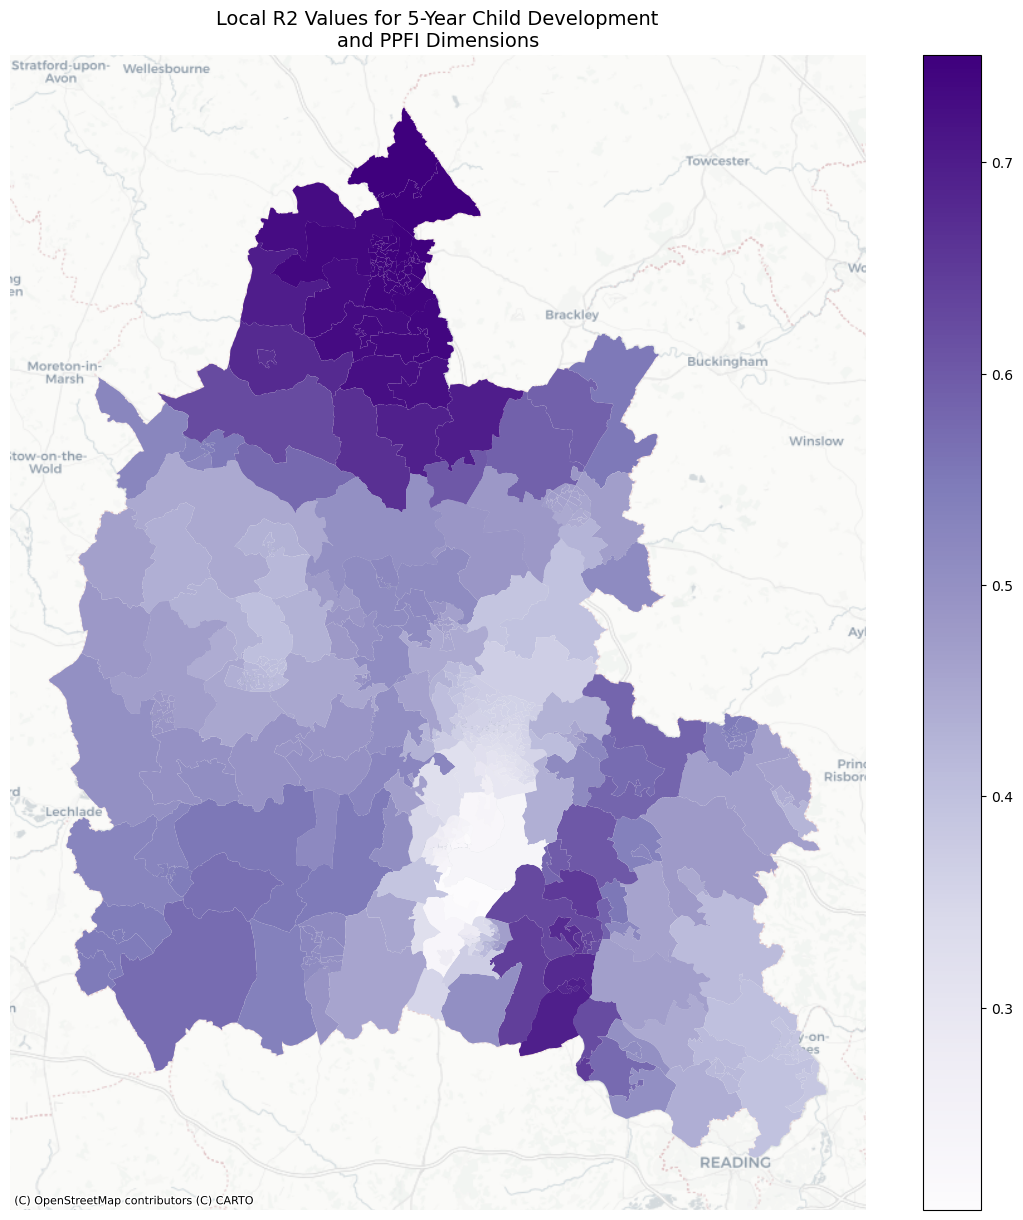

In [16]:
# plot the R2 values
ppfi_Ox_Reordered['R2'] = gwr_results.localR2

# define custom color map for R2
vmin = ppfi_Ox_Reordered['R2'].min()
vmax = ppfi_Ox_Reordered['R2'].max()
norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter = (vmin+vmax)/2, vmax=vmax)

fig,ax = plt.subplots(figsize=(15,15))
ppfi_Ox_Reordered.to_crs('EPSG:3857').plot(ax=ax, column='R2', legend=True, cmap='Purples', norm=norm)
plt.axis('off')
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
title = 'Local R2 Values for 5-Year Child Development and PPFI Dimensions'
wrapped_title = '\n'.join(textwrap.wrap(title,45))
plt.title(wrapped_title, fontsize=14)
plt.show()

### View the average R-squared values by district

In [17]:
ppfi_Ox_Reordered[['District','R2']].groupby('District').mean().reset_index()

District        R2
0             Cherwell  0.609514
1               Oxford  0.353019
2    South Oxfordshire  0.477265
3  Vale of White Horse  0.389542
4     West Oxfordshire  0.471973

### Explore the coefficient estimates by creating a dataframe containing all values

In [18]:
# Create a table for the Model coefficients and intercept values
model_parameters_5YDev = pd.DataFrame(gwr_results.params, 
                               columns = ['Intercept','Supermarket Proximity', 
                                          'Supermarket Accessibility','Non-Supermarket Proximity',
                                          'Fuel Poverty','Socio-demographic Barriers','Food Support for Families',
                                          'E-Commerce Access']
                               )

# add the geometry and LSOA columns to the model parameters dataframe
model_parameters_5YDev = model_parameters_5YDev.assign(LSOA11CD = ppfi_Ox_Reordered['LSOA11CD'])
model_parameters_5YDev = model_parameters_5YDev.assign(LSOA11NM = ppfi_Ox_Reordered['LSOA11NM'])
model_parameters_5YDev = model_parameters_5YDev.assign(geometry = ppfi_Ox_Reordered['geometry'])
model_parameters_5YDev = model_parameters_5YDev.assign(localR2 = ppfi_Ox_Reordered['R2'])
model_parameters_5YDev = model_parameters_5YDev.assign(District = ppfi_Ox_Reordered['District'])

### Create a summary of the model parameters for each of the five districts

In [19]:
Districts_modelParams = model_parameters_5YDev[['Intercept', 'Supermarket Proximity', 'Supermarket Accessibility',
       'Non-Supermarket Proximity', 'Fuel Poverty',
       'Socio-demographic Barriers', 'Food Support for Families',
       'E-Commerce Access','District']].groupby('District').agg(['mean','median'])
Districts_modelParams = Districts_modelParams.round(3)
Districts_modelParams.to_excel(f"C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with 5-Year Child Development/Oxfordshire/GWR with 5-Year Child Development.xlsx",
                              sheet_name = "Model 2 District-Level Summary")

### Convert the created dataframe to a GeoPandas one for creating maps

In [20]:
model_parameters_5YDev = gpd.GeoDataFrame(model_parameters_5YDev, geometry='geometry')

### Create maps for the estimated coefficients

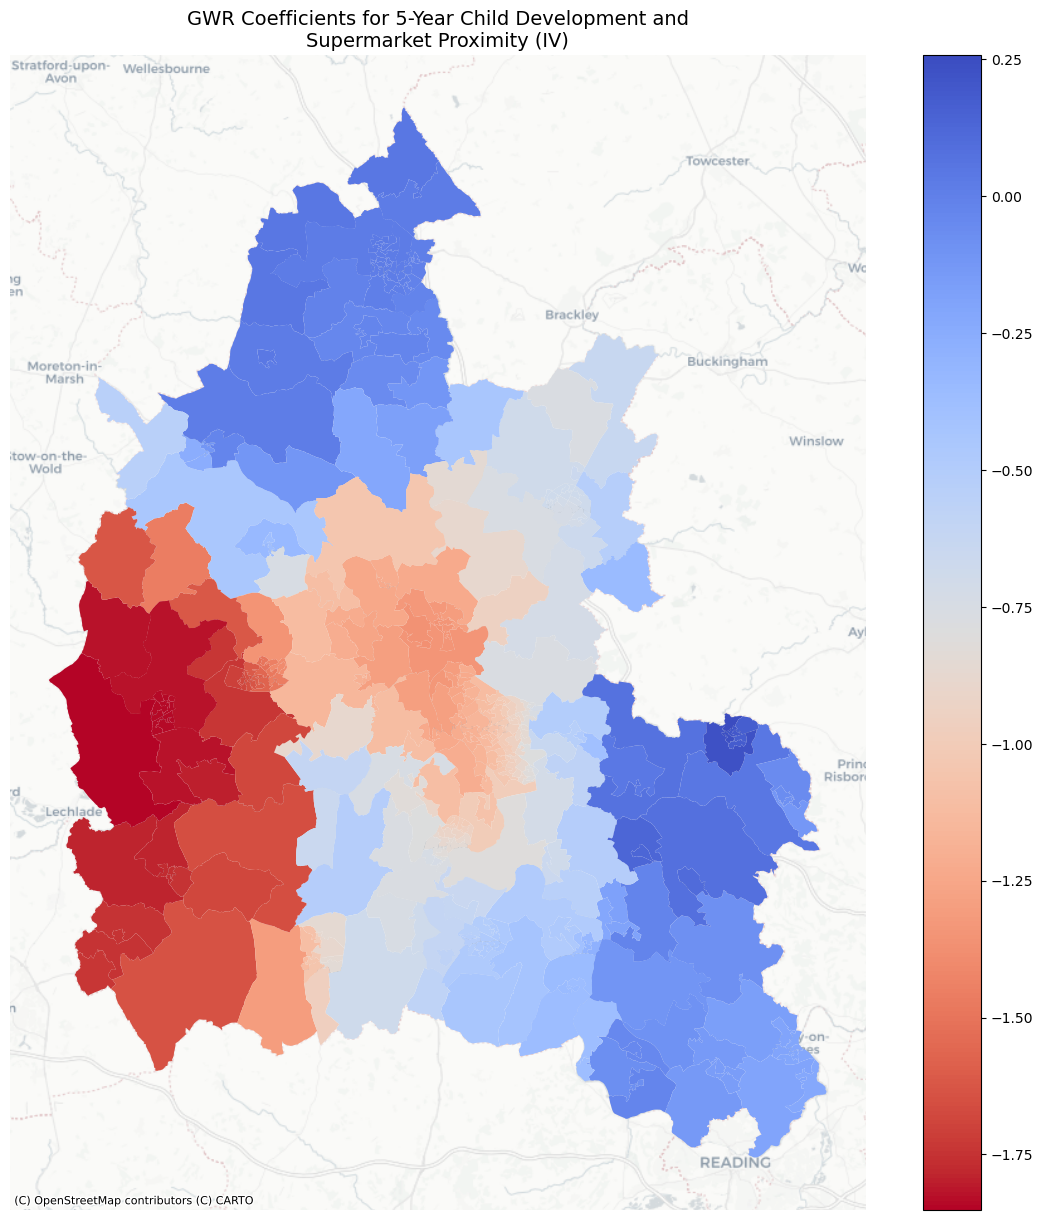

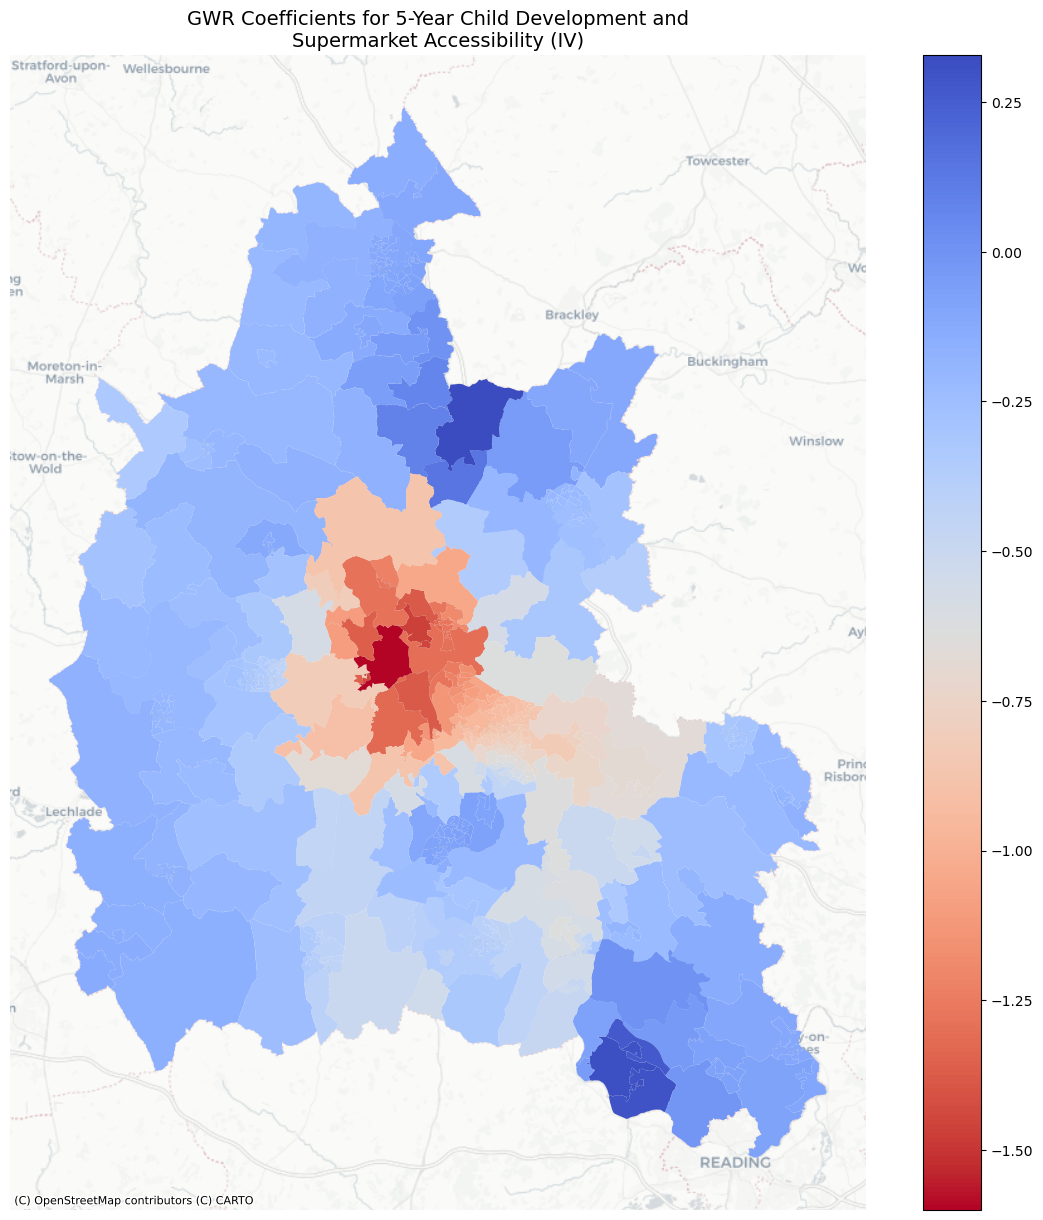

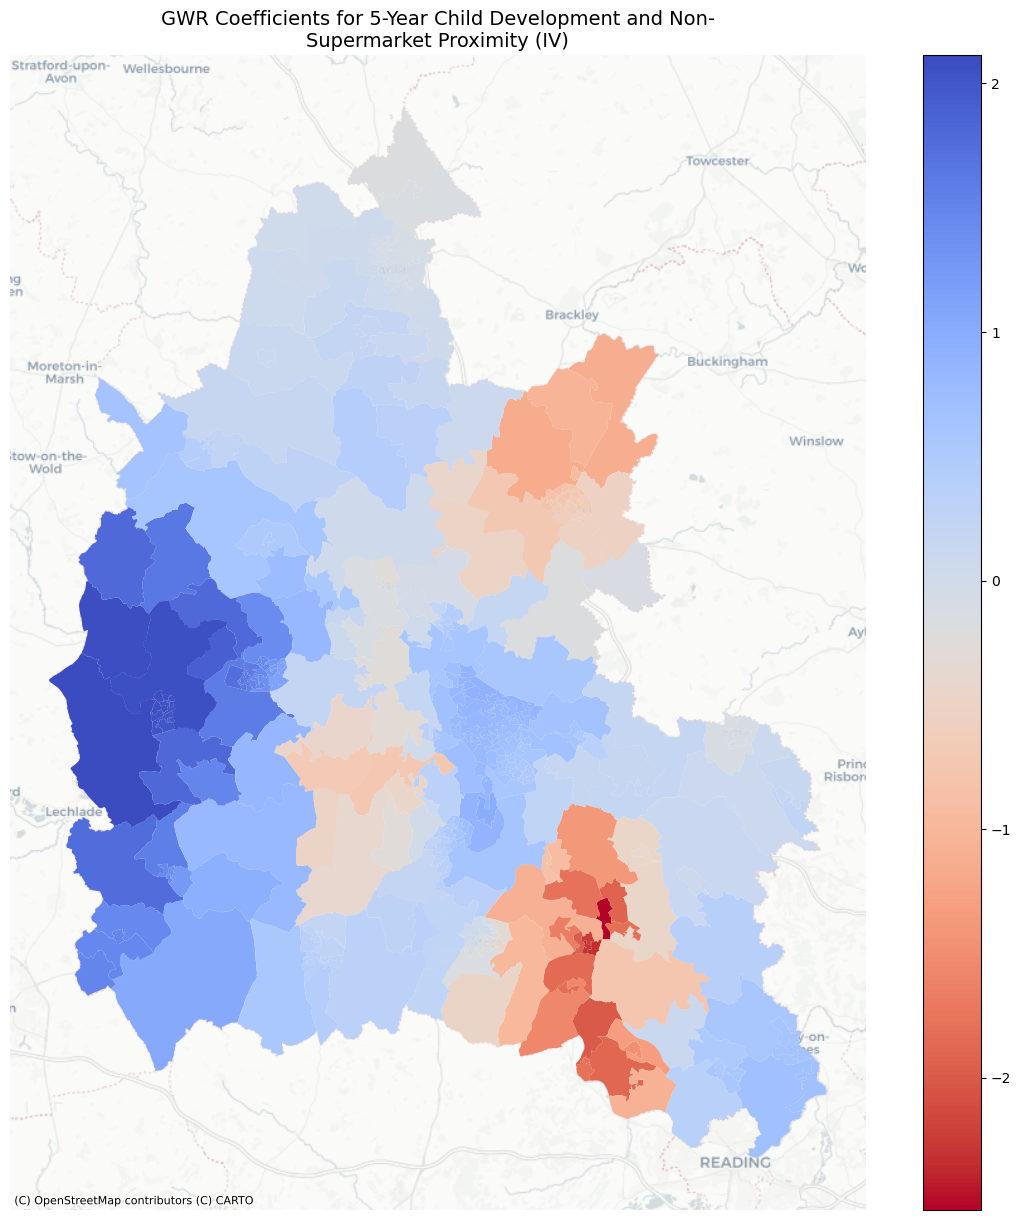

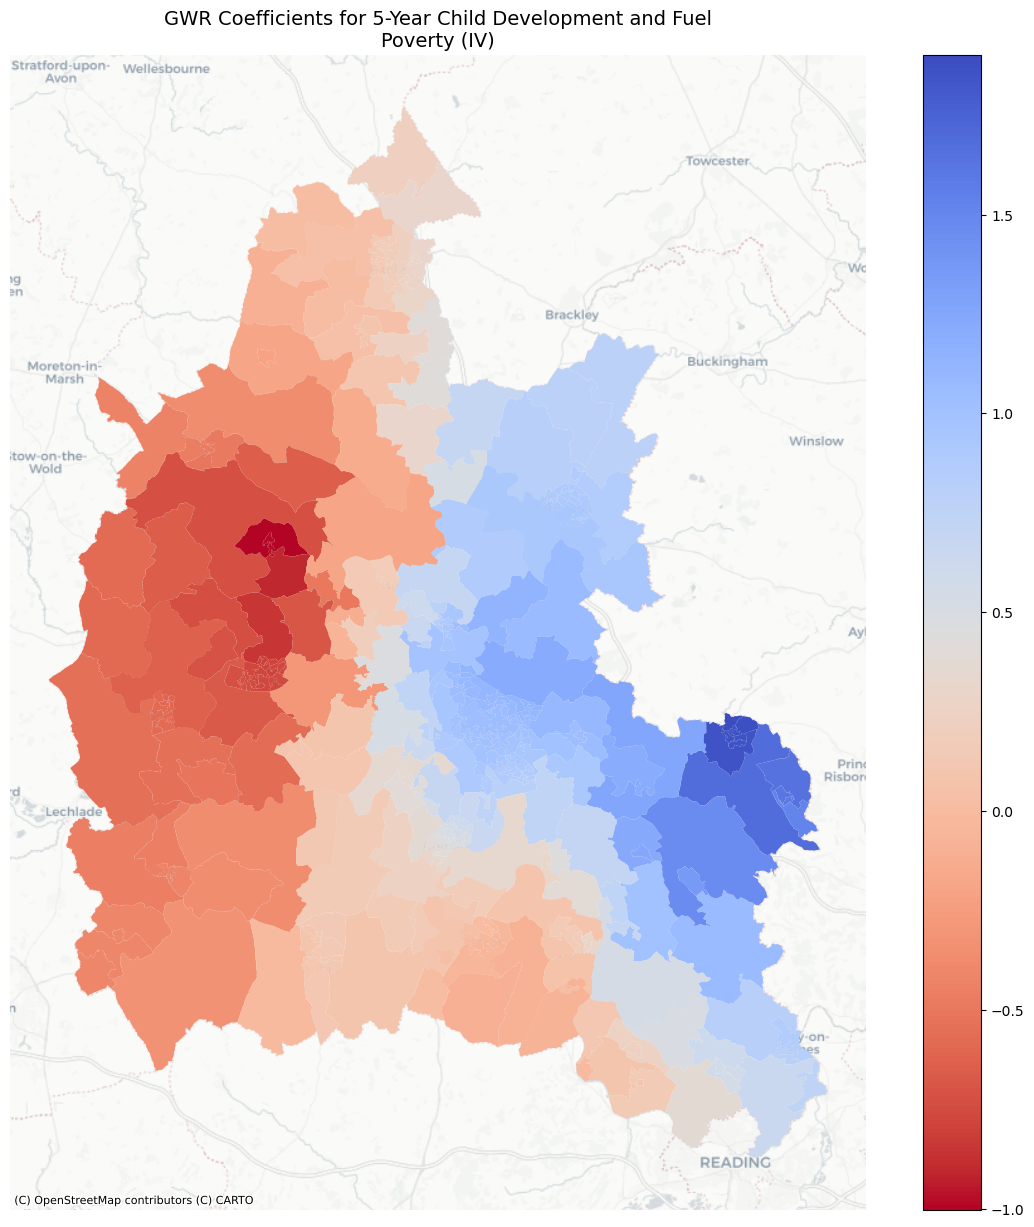

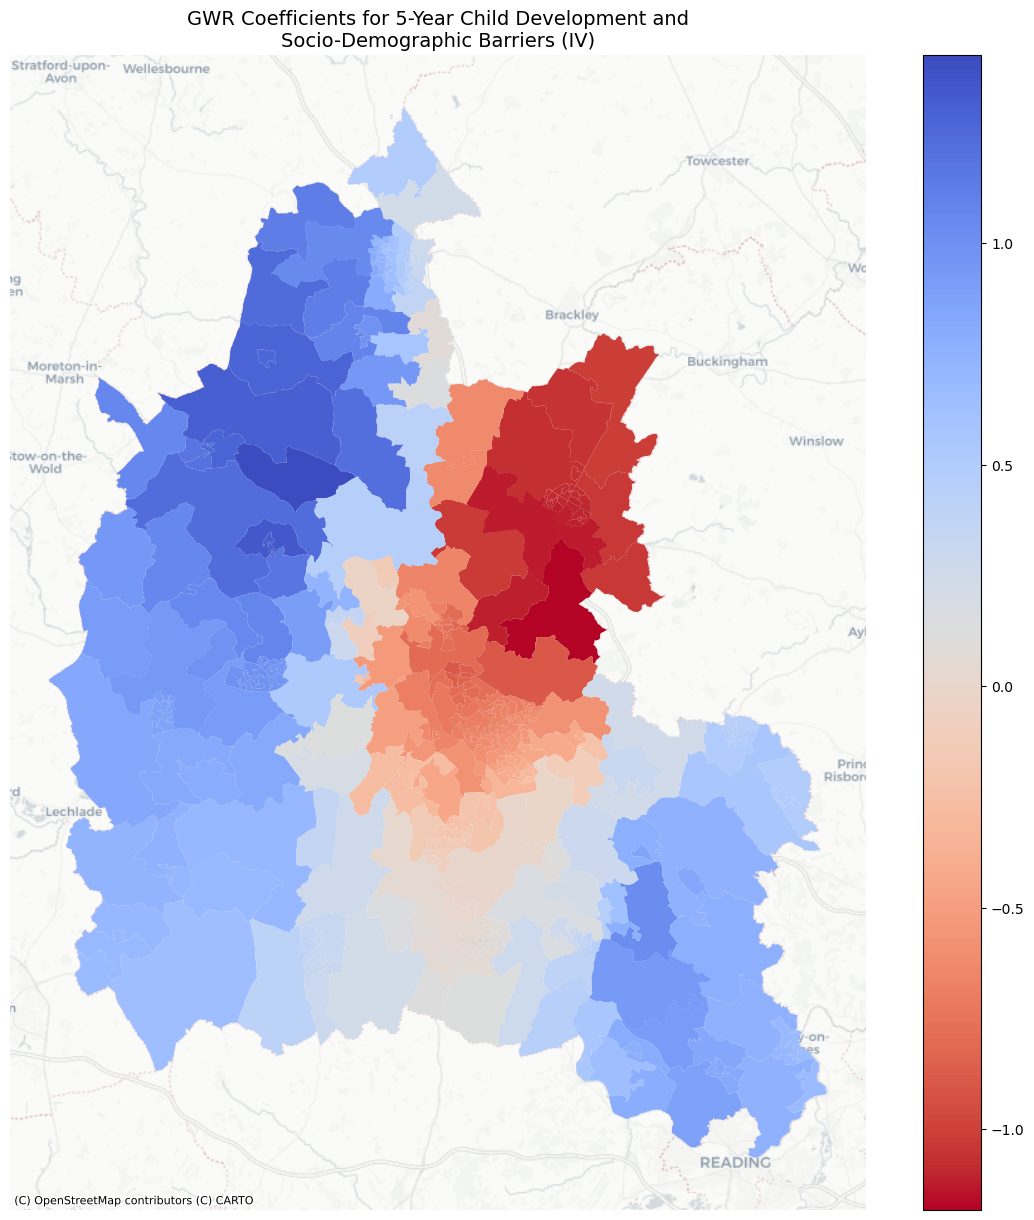

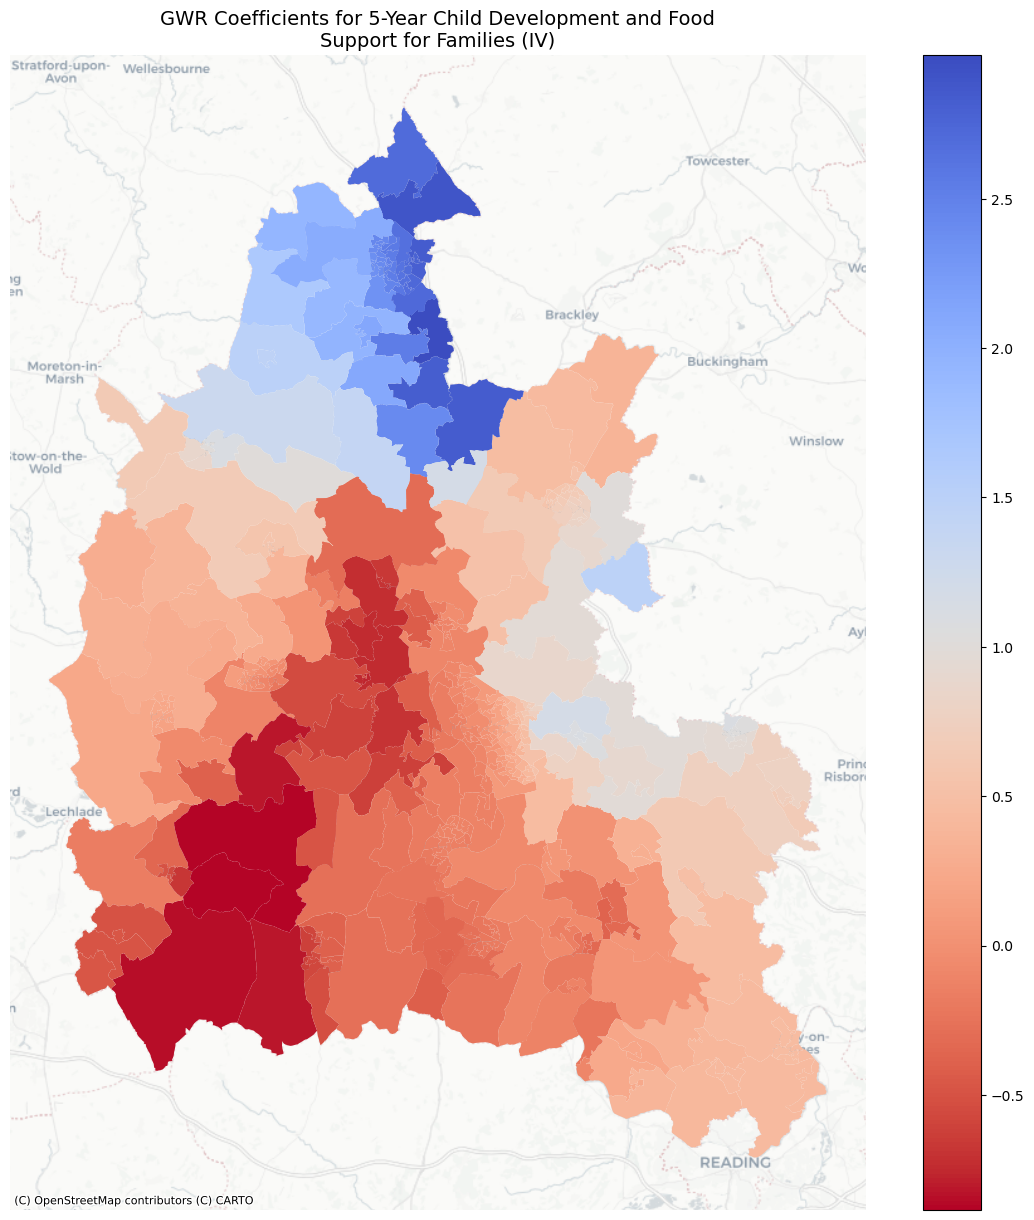

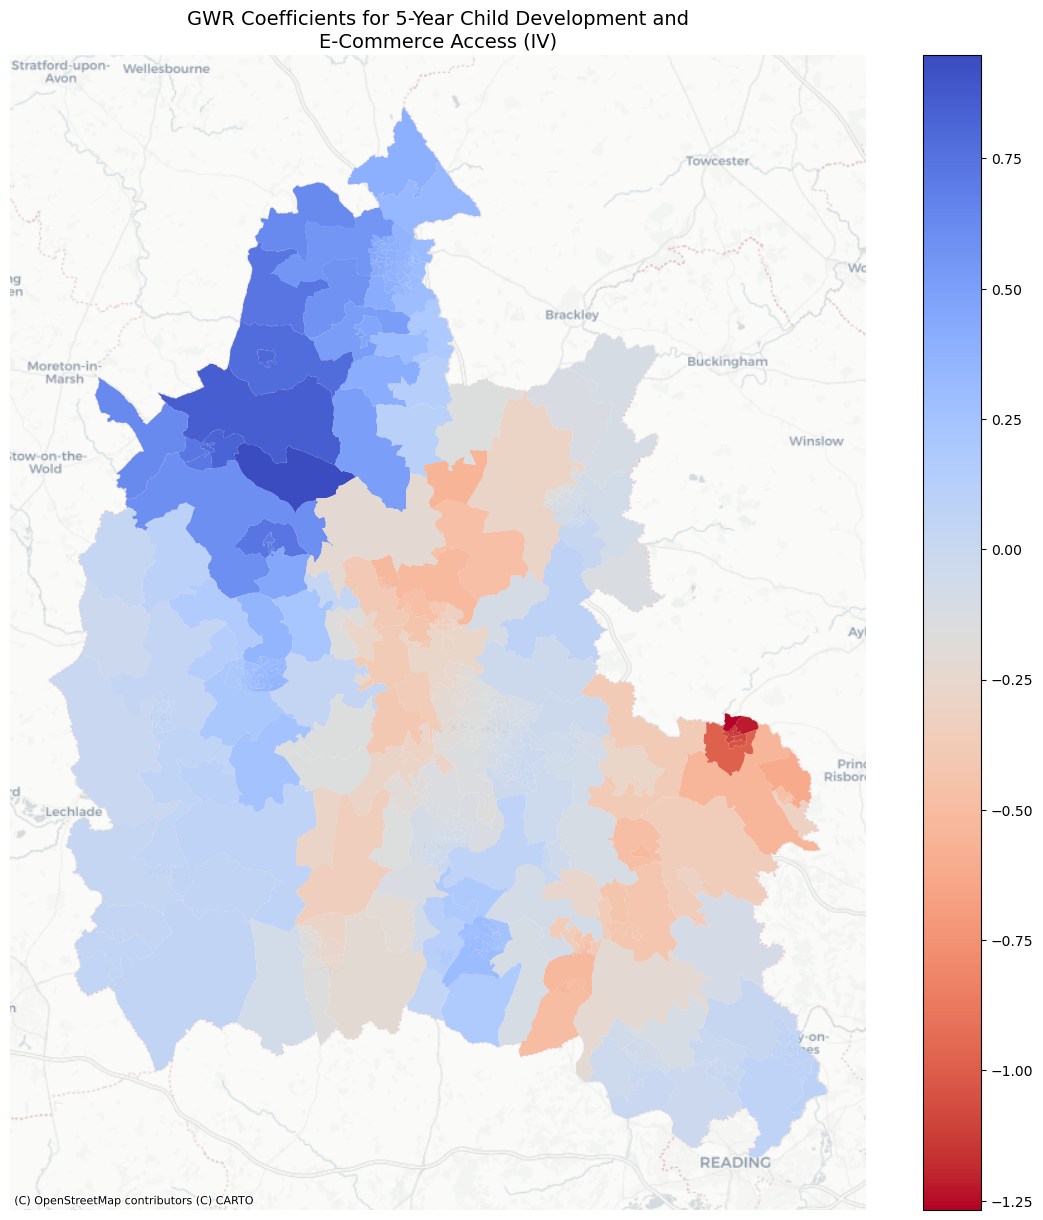

In [21]:
cols = ['Supermarket Proximity', 'Supermarket Accessibility','Non-Supermarket Proximity',
        'Fuel Poverty','Socio-demographic Barriers','Food Support for Families',
        'E-Commerce Access']
titles = ['Supermarket Proximity', 'Supermarket Accessibility', 'Non-Supermarket Proximity', 'Fuel Poverty',
         'Socio-Demographic Barriers','Food Support for Families', 'E-Commerce Access']

for i,col,title in zip(range(len(cols)),cols,titles):
    fig,ax = plt.subplots(figsize=(15,15))
    
    # define custom color map for the coefficients
    vmin = model_parameters_5YDev[col].min()
    vmax = model_parameters_5YDev[col].max()
    norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter = (vmin+vmax)/2, vmax=vmax)
    
    model_parameters_5YDev.to_crs('EPSG:3857').plot(ax=ax, column=col, legend=True, cmap='coolwarm_r',
                                                        norm=norm)
    title = f"GWR Coefficients for 5-Year Child Development and {title} (IV)"
    wrapped_title = '\n'.join(textwrap.wrap(title,55))
    plt.title(wrapped_title, fontsize=14)
    ax.set_axis_off()
    ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
    plt.show()

### Define a color map for the significant coefficient estimates

In [22]:
# define the color map, with white at zero
vmin = -3
vmax = 3
norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap="RdBu"

## Explore Model Diagnostics

### Check the summary of the model results

In [23]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 429
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          21835.394
Log-likelihood:                                                   -1451.673
AIC:                                                               2919.347
AICc:                                                              2921.776
BIC:                                                              19283.521
R2:                                                                   0.334
Adj. R2:                                                              0.323

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Generate a statistical summary of the model results

In [24]:
parameters_summary = pd.DataFrame()
col_names = ['Intercept', 'Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
            'Fuel Poverty','Socio-Demographic Barriers','Family Food Support','E-Commerce Access']
lst = ['Mean','STD','Min','Median','Max']
parameters_summary['Variable'] = col_names

mean_values = []
sd_values = []
min_values = []
median_values = []
max_values = []

gwr_results_df = pd.DataFrame(gwr_results.params)

for i in range(8):
    mean = gwr_results_df[i].mean()
    mean_values.append(round(mean,3))
    
    std = gwr_results_df[i].std()
    sd_values.append(round(std,3))
    
    minimum = gwr_results_df[i].min()
    min_values.append(round(minimum,3))
    
    maximum = gwr_results_df[i].max()
    max_values.append(round(maximum,3))
    
    median = gwr_results_df[i].median()
    median_values.append(round(median,3))

parameters_summary['Mean'] = mean_values
parameters_summary['STD'] = sd_values
parameters_summary['Min'] = min_values
parameters_summary['Median'] = median_values
parameters_summary['Max'] = max_values

### Export the Parameters Summary to an Excel file

In [25]:
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with 5-Year Child Development/Oxfordshire/GWR with 5-Year Child Development.xlsx",
                   engine="openpyxl", mode="a") as writer:
    parameters_summary.to_excel(writer, sheet_name = "Model 2 Parameters Summary")

### Define a formatting style for the plots to come

In [26]:
kwargs = {'edgecolor':'black',
         'linewidth':0.5
         }

### Visualizing the statistical significance of the parameter estimates

In [27]:
# default behaviour using corrected alpha
filter_tc = gwr_results.filter_tvals()

# without correction using common alpha
filter_t = gwr_results.filter_tvals(alpha=0.05)

# create a dataframe for the parameter estimates
parameter_estimates = pd.DataFrame()

# column names used to loop through and capture the model estimates
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
                        'Fuel Poverty','Socio-demographic Barriers',
                        'Food Support for Families','E-Commerce Access']

# loop through to capture the parameter estimates
for col,i in list(zip(columns_significance, range(1,8))):
    parameter_estimates[col] = gwr_results.params[:,i]
    parameter_estimates[col+"_t"] = filter_t[:,i]
    parameter_estimates[col+"_tc"] = filter_tc[:,i]

# add other useful columns 
parameter_estimates[['LSOA11CD','LSOA11NM','geometry','District']] = ppfi_Ox_Reordered[['LSOA11CD','LSOA11NM','geometry','District']]

# convert the merged dataframe to a GeoPandas one
parameter_estimates = gpd.GeoDataFrame(parameter_estimates, geometry='geometry').to_crs('EPSG:3857')

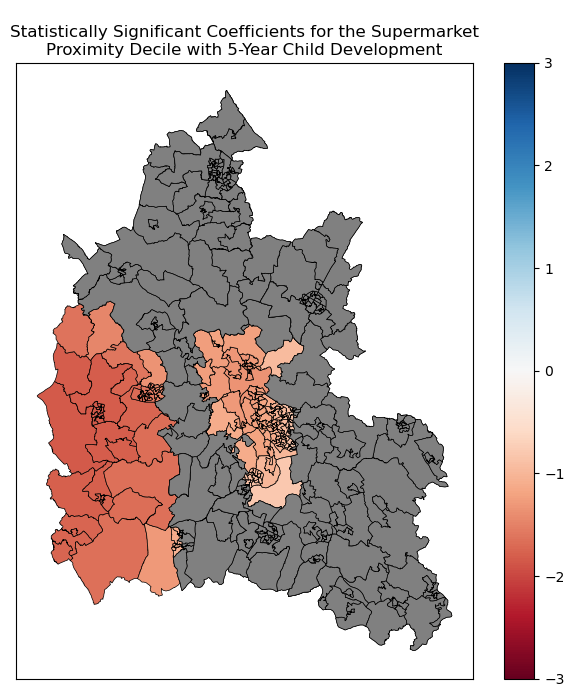

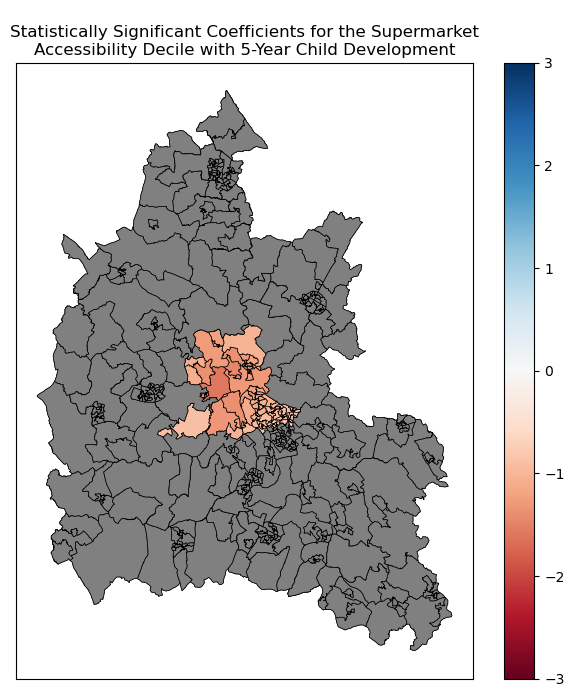

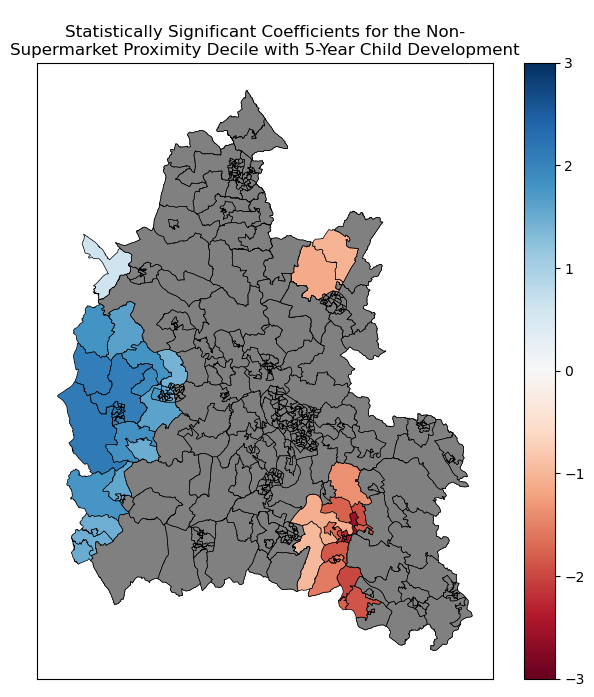

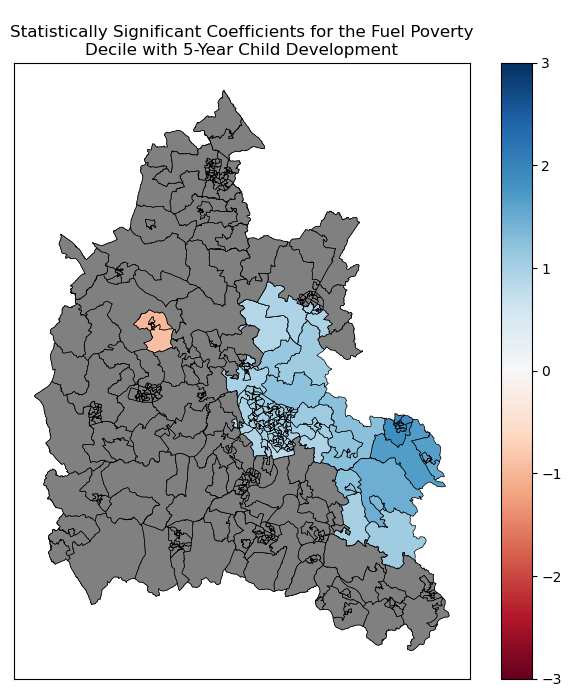

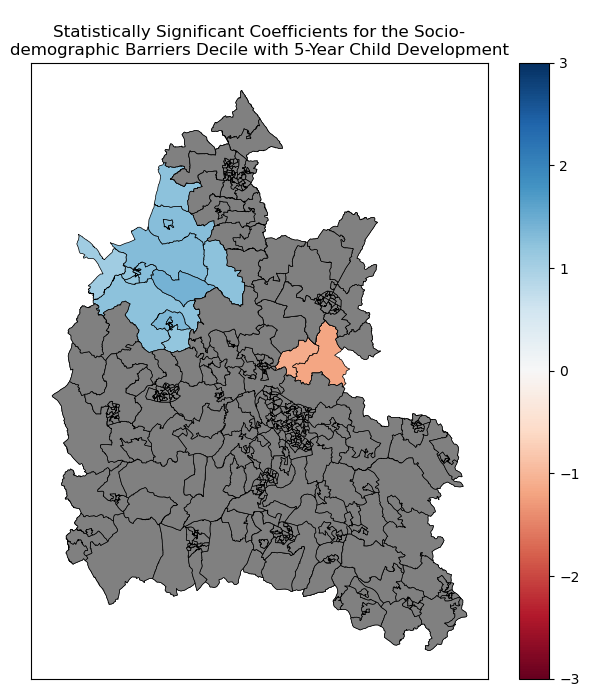

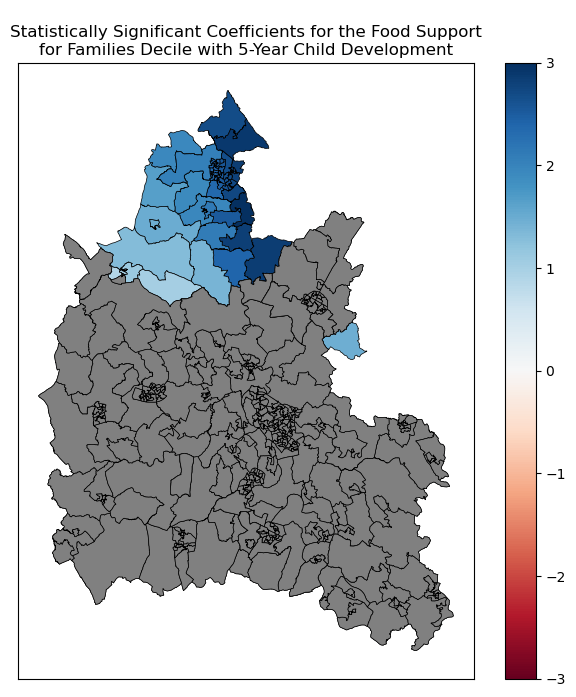

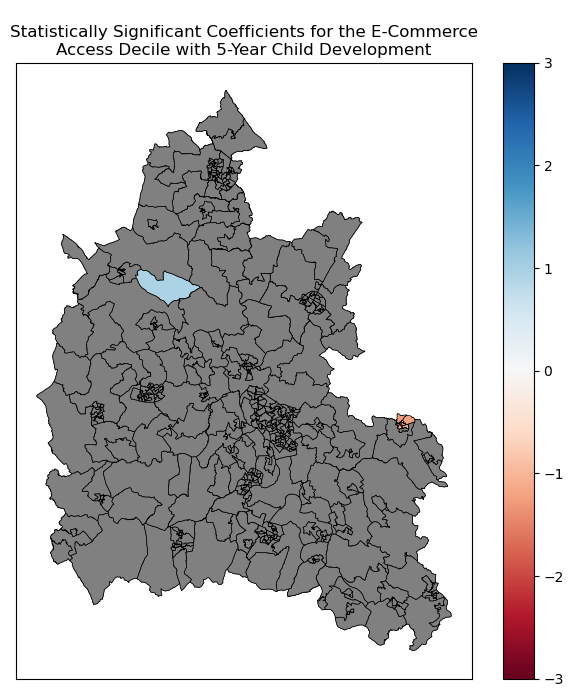

In [28]:
# define a list of column names used to generate the maps
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
                        'Fuel Poverty','Socio-demographic Barriers',
                        'Food Support for Families','E-Commerce Access']

# define a list of dimension names to used to set titles for the maps
title_dimensions = ['Supermarket Proximity',
                   'Supermarket Accessibility',
                   'Non-Supermarket Proximity',
                   'Fuel Poverty',
                   'Socio-demographic Barriers',
                    'Food Support for Families',
                   'E-Commerce Access']

# create the maps
for col,title in list(zip(columns_significance,title_dimensions)):
    fig,ax = plt.subplots(figsize=(8,8))
    parameter_estimates.plot(
    col,
    ax=ax,
    legend=True,
    **kwargs,
    cmap=cmap,
    norm=norm
    )
    parameter_estimates[parameter_estimates[col+'_tc'] == 0].plot(ax=ax,
                                                                 color='grey',
                                                                 **kwargs)
    title = f"Statistically Significant Coefficients for the {title} Decile with 5-Year Child Development"
    ax.set_title("\n".join(textwrap.wrap(title,60)))                                                             
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [29]:
# define a list of dimensions names used to capture the parameter estimates
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
                        'Fuel Poverty','Socio-demographic Barriers',
                        'Food Support for Families','E-Commerce Access']

# define a list for the sheet names used when exporting the outputs to excel
sheet_names = ['SM_Prox','SM_Acc','NonSM_Prox','FuelPov','SD','FFF','E_Comm']

# define a dictionnary showing the district names and the total LSOAs (2011) count of each to add that 
# to the district summaries
LSOAs_Count = {
    "Cherwell":102,
    "South Oxfordshire":93,
    "West Oxfordshire":68,
    "Vale of White Horse":81,
    "Oxford":85
}

# list of statistical measures
lst = ['Mean','Median','Minimum','Maximum']

# create the statistical summary
for col,sheet_name in zip(columns_significance, sheet_names):
    district_estimates = parameter_estimates[parameter_estimates[col+"_tc"] !=0].groupby('District').agg(
        LSOA_Count = ('LSOA11CD','nunique'),
        Mean=(col,'mean'),
        Median = (col,'median'),
        Minimum = (col,'min'),
        Maximum = (col,'max'),
    ).reset_index()
    district_estimates['Total_LSOAs'] = district_estimates['District'].map(LSOAs_Count)
    district_estimates['LSOA_Coverage'] = round(district_estimates['LSOA_Count']/district_estimates['Total_LSOAs']*100,2)
    district_estimates[lst] = district_estimates[lst].round(3)
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with 5-Year Child Development/Oxfordshire/GWR with 5-Year Child Development.xlsx",
                   engine="openpyxl", mode="a") as writer:
            district_estimates.to_excel(writer, sheet_name = f"Summary_{sheet_name}")

### Get the significant LSOAs list for each District and Dimension

In [30]:
# loop through and export the outputs to excel
for col,sheet_name in zip(columns_significance,sheet_names):
    Sig_LSOA_list = parameter_estimates[parameter_estimates[col+"_tc"] != 0].round(3)
    Sig_LSOA_list = Sig_LSOA_list[['LSOA11CD','District',col]].merge(Ox_dem[['LSOA11CD','LSOA21CD','LSOA21NM','RUC11']], 
                                                                             on='LSOA11CD',how='inner').reset_index()
    Sig_LSOA_list = Sig_LSOA_list.round(3)
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with 5-Year Child Development/Oxfordshire/GWR with 5-Year Child Development.xlsx",
                         engine="openpyxl", mode="a") as writer:
        Sig_LSOA_list.to_excel(writer, sheet_name = f"Sig_{sheet_name}")

### Group the district-level estimates of LSOAs by the RUC classification

In [31]:
# create a dictionnary of the Cherwell LSOAs count by RUC classification 
District_RUC_LSOA_Count = {
    "Cherwell":{
        "Urban city and town": 69,
        "Rural village and dispersed": 26,
        "Rural town and fringe": 7
    },
    "South Oxfordshire":{
        "Urban city and town": 49,
        "Rural village and dispersed": 21,
        "Rural town and fringe": 23
    },
    "West Oxfordshire":{
        "Urban city and town": 28,
        "Rural village and dispersed": 19,
        "Rural town and fringe": 21
    },
    "Oxford":{
        "Urban city and town": 84,
        "Rural village and dispersed": 0,
        "Rural town and fringe": 1
    },
    "Vale of White Horse":{
        "Urban city and town": 49,
        "Rural village and dispersed": 10,
        "Rural town and fringe": 22
    }
}

# define a function to get the LSOA count values from the dictionnary defined above
def get_value(row):
    return District_RUC_LSOA_Count[row["District"]][row['RUC11']]

# create the dataframe and export to excel
for col,sheet_name in zip(columns_significance,sheet_names):
    Grouped_RUC = parameter_estimates[parameter_estimates[col+"_tc"] != 0]
    Grouped_RUC = Grouped_RUC[['LSOA11CD','District',col]].merge(Ox_dem[['LSOA11CD','RUC11']], on='LSOA11CD', how='inner')
    Grouped_RUC = Grouped_RUC.groupby(['District','RUC11']).agg(
        LSOA_Count = ('LSOA11CD','nunique'),
        Coeff_Average = (col,'mean')
    ).reset_index()
    Grouped_RUC['Total_LSOAs'] = Grouped_RUC.apply(get_value, axis=1)
    Grouped_RUC['Coeff_Average'] = round(Grouped_RUC['Coeff_Average'],3)
    Grouped_RUC['LSOA_Coverage'] = round(Grouped_RUC['LSOA_Count']/Grouped_RUC['Total_LSOAs']*100,2)
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with 5-Year Child Development/Oxfordshire/GWR with 5-Year Child Development.xlsx",
                   engine="openpyxl", mode="a") as writer:
        Grouped_RUC.to_excel(writer, sheet_name = f"Sig_RUC_{sheet_name}")

## Fit a GWR model with 5-Year Child Development as the dependent variable and the combined PPFI decile as the independent variable

### Define the variables

In [32]:
# define the dependent variable as the percentage of well-developed children at age 5
y = ppfi_Ox_Reordered['Child Development at Age 5'].values.reshape(-1,1)

# define the independent variables as the dimensions of the PPFI
X = ppfi_Ox_Reordered[['PPFI Combined Decile']].values

y = np.array(y)
X = np.array(X)

### Define the coordinates

In [33]:
u = points.x
v = points.y
coords = list(zip(u,v))

### Calibrate the model to compute the optimal bandwidth

In [34]:
gwr_selector = Sel_BW(coords, y, X, kernel='bisquare')
gwr_bw = gwr_selector.search()
print(gwr_bw)

45.0


### Fit the model

In [35]:
gwr_model = GWR(coords, y, X, bw=gwr_bw, kernel='bisquare')

### Get the results

In [36]:
gwr_results = gwr_model.fit()

### Get the global R-squared value

In [37]:
global_R2 = gwr_results.R2
print(global_R2)

0.6124179824290061


## Model Diagnostics

### View the statistical summary of the model results

In [38]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 429
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          31582.333
Log-likelihood:                                                   -1530.838
AIC:                                                               3065.676
AICc:                                                              3067.732
BIC:                                                              28994.091
R2:                                                                   0.037
Adj. R2:                                                              0.035

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Create a statistical summary of the model parameters

In [39]:
parameters_summary = pd.DataFrame()
col_names = ['Intercept', 'Combined Decile']
lst = ['Mean','STD','Min','Median','Max']
parameters_summary['Variable'] = col_names

mean_values = []
sd_values = []
min_values = []
median_values = []
max_values = []

gwr_results_df = pd.DataFrame(gwr_results.params)

for i in range(2):
    mean = gwr_results_df[i].mean()
    mean_values.append(round(mean,3))
    
    std = gwr_results_df[i].std()
    sd_values.append(round(std,3))
    
    minimum = gwr_results_df[i].min()
    min_values.append(round(minimum,3))
    
    maximum = gwr_results_df[i].max()
    max_values.append(round(maximum,3))
    
    median = gwr_results_df[i].median()
    median_values.append(round(median,3))

parameters_summary['Mean'] = mean_values
parameters_summary['STD'] = sd_values
parameters_summary['Min'] = min_values
parameters_summary['Median'] = median_values
parameters_summary['Max'] = max_values

### Export the statistical summary to an excel file

In [40]:
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with 5-Year Child Development/Oxfordshire/GWR with 5-Year Child Development.xlsx",
                   engine="openpyxl", mode="a") as writer:
    parameters_summary.to_excel(writer, sheet_name = "Model 1 Parameters Summary")

### Export the statistical summary to an excel file

### Visualize the statistical significance of the parameter estimates

In [41]:
# default behaviour using corrected alpha
filter_tc = gwr_results.filter_tvals()

# without correction using common alpha
filter_t = gwr_results.filter_tvals(alpha=0.05)

# create a dataframe for the parameter estimates
parameter_estimates = pd.DataFrame()

# capture the parameter estimates
parameter_estimates['PPFI Combined Decile'] = gwr_results.params[:,1]
parameter_estimates['PPFI Combined Decile_t'] = filter_t[:,1]
parameter_estimates['PPFI Combined Decile_tc'] = filter_tc[:,1]

# add other useful columns 
parameter_estimates[['LSOA11CD','LSOA11NM','geometry','District']] = ppfi_Ox_Reordered[['LSOA11CD','LSOA11NM','geometry','District']]

# convert the merged dataframe to a GeoPandas one
parameter_estimates = gpd.GeoDataFrame(parameter_estimates, geometry='geometry').to_crs('EPSG:3857')

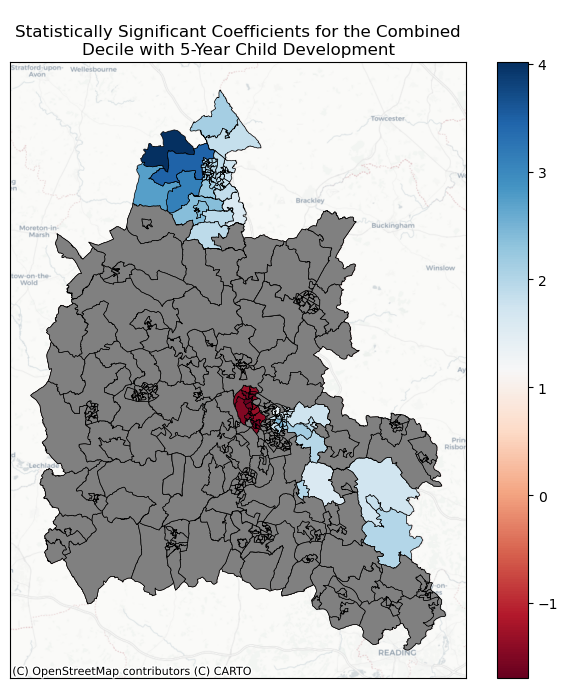

In [42]:
# generate the map of the statistically significant parameter estimates
fig,ax = plt.subplots(figsize=(8,8))

parameter_estimates.plot(
    'PPFI Combined Decile',
    ax=ax,
    legend=True,
    **kwargs,
    cmap=cmap
)

parameter_estimates[filter_tc[:,1] == 0].plot(ax=ax,
                                              color='grey',
                                            **kwargs
                                             )
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = f"Statistically Significant Coefficients for the Combined Decile with 5-Year Child Development"
ax.set_title("\n".join(textwrap.wrap(title,60)))  
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)

plt.show()

In [43]:
district_estimates = parameter_estimates[filter_tc[:,1] !=0].groupby('District').agg(LSOA_Count = ('LSOA11CD','nunique'),
                                            Mean = ('PPFI Combined Decile','mean'),
                                            Median = ('PPFI Combined Decile','median'),
                                            Minimum = ('PPFI Combined Decile','min'),
                                            Maximum = ('PPFI Combined Decile','max')
                                                               )
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with 5-Year Child Development/Oxfordshire/GWR with 5-Year Child Development.xlsx",
                   engine="openpyxl", mode="a") as writer:
    district_estimates.to_excel(writer, sheet_name = "Model1_Sig")

### Notes

The results from Model 1 show that tackling food insecurity could contribute the most to enhancing children's levels of development at age 5 in Cherwell and South Oxfordshire.

In [44]:
ppfi_Ox_Reordered[['District','Child Development at Age 5']].groupby('District').mean().reset_index()

District  Child Development at Age 5
0             Cherwell                   61.450980
1               Oxford                   55.740000
2    South Oxfordshire                   65.397849
3  Vale of White Horse                   58.128395
4     West Oxfordshire                   65.972059

#### Barriers to Food Purchase (Supermarket Proximity/Accessibility - Non-Supermarket Proximity - E-commerce access)

- Model 2 results show that tackling barriers to food purchase might not be a major contributor towards enhancing children's development in Oxfordshire.
- The only exception is the non-supermarket proximity domain which has some significant and positive coefficients in Vale of White Horse and West Oxfordshire.
- E-commerce also has a positive and significant coefficient in 1 LSOA in West Oxfordshire.
- It is interesting that in most cases, areas which have significant and negative coefficients tend to be urban cities (primarily) or rural villages rather than rural towns. This could be an indication that there are various other factors which affect a child's development which particularly relate to lifestyle, day-to-day physical activities and play, as well as education. Children in urban areas possibly spend less time outdoors and engaging in physical activities which would lead to a poor level of development at the age of 5. These factors are not directly related to barriers to food purchase.

#### Poverty and Deprivation (Socio-demographic barriers - food support for families - fuel poverty)

- Model 2 results show that overall, tackling poverty and deprivation in specific parts of Oxfordshire could contribute much more to enhancing the levels of child development at age 5.
- The fuel poverty dimension has the greatest LSOA coverage and coefficient magnitudes in Oxford (97% 1.021 median) and South Oxfordshire (31% 1.351 median). 
- On the other hand, socio-demogaphic barriers show significance in parts of West Oxfordshire primarily (17% 1,228 median).
- Food support for families shows the most significance in Cherwell (48% 1.059 median).
- Fuel poverty in Oxford and parts of South Oxfordshire could be driven by the living expenses in these areas compared to areas in other districts.
- Socio-demographic barriers have significant and positive coefficients in West Oxfordshire - the most rural district in Oxfordshire. 
- Food Support for families has the most significance in Cherwell and in its rural towns, rural villages, and urban areas. The highest percentage LSOA coverage is in rural towns which could be driven mostly by poor access to food banks in these rural areas. 